<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [301]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten, Reshape, BatchNormalization, Input, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time
import os
import tensorflow_datasets as tfds
import imageio
import glob
import IPython

In [302]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [303]:
#@title CONFIG

IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
LATENT_DIM = 100
EPOCHS = 20
SAMPLE_INTERVAL = 1
DATASET_SIZE = 60000
SAMPLES_DIR = 'images'
PER_REPILICA_BATCH_SIZE = 16
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync

In [304]:
def preprocess_image(img):
  img = tf.cast(img['image'], tf.float32) / 127.5 - 1.
  # img = tf.expand_dims(img, axis=3)
  return img

ds = tfds.load('mnist', split='train', shuffle_files=True, try_gcs=True)
dataset = ds.map(preprocess_image)
dataset = dataset.shuffle(DATASET_SIZE)
dataset = dataset.repeat()
dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

dataset = strategy.experimental_distribute_dataset(dataset)

In [305]:
class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
   
    self.dense_1 = Dense(7 * 7 * 256, use_bias=False, input_shape=(LATENT_DIM,))
    self.bn_1 = BatchNormalization()
    self.lrelu_1 = LeakyReLU()
    self.reshape_1 = Reshape((7, 7, 256));

    self.conv2d_transpose_1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.bn_2 = BatchNormalization()
    self.lrelu_2 = LeakyReLU()

    self.conv2d_transpose_2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)

    self.bn_3 = BatchNormalization()
    self.lrelu_3 = LeakyReLU()

    self.conv2d_transpose_3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

  @tf.function
  def call(self, z, training=False):    
    x = self.dense_1(z)
    x = self.bn_1(x)
    x = self.lrelu_1(x)
    x = self.reshape_1(x)
    x = self.conv2d_transpose_1(x)
    x = self.bn_2(x)
    x = self.lrelu_2(x)
    x = self.conv2d_transpose_2(x)
    x = self.bn_3(x)
    x = self.lrelu_3(x)
    x = self.conv2d_transpose_3(x)

    return x

In [306]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
        
    self.conv2d_1 = Conv2D(64, (5, 5), 
                        strides=(2, 2), 
                        padding='same', 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS]
                    )

    self.lrelu_1 = LeakyReLU()
    self.dropout_1 = Dropout(0.3)

    self.conv2d_2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
    self.lrelu_2 = LeakyReLU()
    self.dropout_2 = Dropout(0.3)
    self.flatten = Flatten()
    self.dense = Dense(1)
  
  @tf.function
  def call(self, image, training=False):    
    x = self.conv2d_1(image)
    x = self.lrelu_1(x)
    x = self.dropout_1(x)
    x = self.conv2d_2(x)
    x = self.lrelu_2(x)
    x = self.dropout_2(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x

In [307]:
with strategy.scope():
  generator = Generator()
  discriminator = Discriminator()

In [308]:
with strategy.scope():
  generator_optimizer = Adam(1e-4)
  discriminator_optimizer = Adam(1e-4)

In [309]:
with strategy.scope():
  cross_entropy = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
  fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
  total_loss = real_loss + fake_loss

  return tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
  return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

In [310]:
rows = 5
cols = 5

noise = np.random.normal(0, 1, (rows * cols, LATENT_DIM))

def sample_images(epoch=0, save=False, show=True):
  gen_imgs = generator(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * cols + i, :,:,0], cmap='gray')
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

In [311]:
@tf.function
def train_step(iterator):

  def step_fn(images):
    noise = tf.random.normal([PER_REPILICA_BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      gen_predictions = discriminator(generated_images, training=True)
      real_predictions = discriminator(images, training=True)
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_weights)
    )

    return disc_loss, gen_loss


  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, gen_loss, axis=None) 

  return disc_loss, gen_loss

Number of devices: 8
Epoch: 1/20


Current step 468: 100%|██████████| 468/468 [00:27<00:00, 17.27it/s, disc_loss=1.08, gen_loss=0.907]


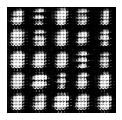

Time for epoch 1 is 29.789719343185425 sec
Epoch: 2/20


Current step 936: 100%|██████████| 468/468 [00:11<00:00, 40.88it/s, disc_loss=1.2, gen_loss=0.892]


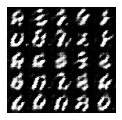

Time for epoch 2 is 12.349915742874146 sec
Epoch: 3/20


Current step 1404: 100%|██████████| 468/468 [00:11<00:00, 41.20it/s, disc_loss=1.07, gen_loss=0.965]


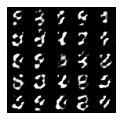

Time for epoch 3 is 12.295218467712402 sec
Epoch: 4/20


Current step 1872: 100%|██████████| 468/468 [00:11<00:00, 40.48it/s, disc_loss=1.18, gen_loss=0.93]


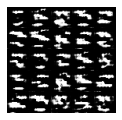

Time for epoch 4 is 12.786808252334595 sec
Epoch: 5/20


Current step 2340: 100%|██████████| 468/468 [00:11<00:00, 41.11it/s, disc_loss=1.28, gen_loss=0.914]


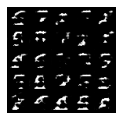

Time for epoch 5 is 12.26381540298462 sec
Epoch: 6/20


Current step 2808: 100%|██████████| 468/468 [00:11<00:00, 40.61it/s, disc_loss=1.23, gen_loss=1.02]


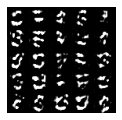

Time for epoch 6 is 12.401694297790527 sec
Epoch: 7/20


Current step 3276: 100%|██████████| 468/468 [00:11<00:00, 40.38it/s, disc_loss=1.21, gen_loss=0.9]


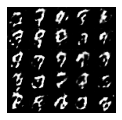

Time for epoch 7 is 12.853981971740723 sec
Epoch: 8/20


Current step 3744: 100%|██████████| 468/468 [00:13<00:00, 35.96it/s, disc_loss=1.22, gen_loss=1.12]


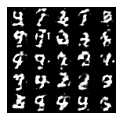

Time for epoch 8 is 13.907564401626587 sec
Epoch: 9/20


Current step 4212: 100%|██████████| 468/468 [00:11<00:00, 40.35it/s, disc_loss=1.33, gen_loss=1.18]


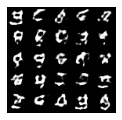

Time for epoch 9 is 12.544555902481079 sec
Epoch: 10/20


Current step 4680: 100%|██████████| 468/468 [00:11<00:00, 39.91it/s, disc_loss=1.06, gen_loss=1.32]


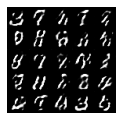

Time for epoch 10 is 13.068912029266357 sec
Epoch: 11/20


Current step 5148: 100%|██████████| 468/468 [00:11<00:00, 39.99it/s, disc_loss=1.11, gen_loss=1.12]


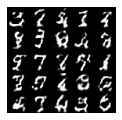

Time for epoch 11 is 12.58845591545105 sec
Epoch: 12/20


Current step 5616: 100%|██████████| 468/468 [00:11<00:00, 39.14it/s, disc_loss=1.33, gen_loss=1.21]


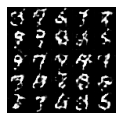

Time for epoch 12 is 12.84143853187561 sec
Epoch: 13/20


Current step 6084: 100%|██████████| 468/468 [00:11<00:00, 39.65it/s, disc_loss=0.929, gen_loss=1.35]


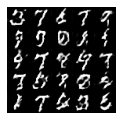

Time for epoch 13 is 13.118158340454102 sec
Epoch: 14/20


Current step 6552: 100%|██████████| 468/468 [00:11<00:00, 39.63it/s, disc_loss=1.13, gen_loss=1.2]


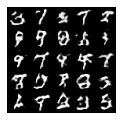

Time for epoch 14 is 12.76282262802124 sec
Epoch: 15/20


Current step 7020: 100%|██████████| 468/468 [00:11<00:00, 39.66it/s, disc_loss=1.21, gen_loss=0.962]


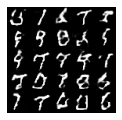

Time for epoch 15 is 12.681514263153076 sec
Epoch: 16/20


Current step 7488: 100%|██████████| 468/468 [00:11<00:00, 39.50it/s, disc_loss=1.05, gen_loss=1.21]


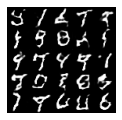

Time for epoch 16 is 13.166437864303589 sec
Epoch: 17/20


Current step 7956: 100%|██████████| 468/468 [00:11<00:00, 39.63it/s, disc_loss=1.14, gen_loss=1.23]


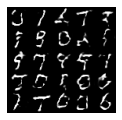

Time for epoch 17 is 12.735613822937012 sec
Epoch: 18/20


Current step 8424: 100%|██████████| 468/468 [00:11<00:00, 39.64it/s, disc_loss=1.25, gen_loss=0.893]


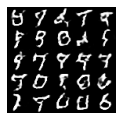

Time for epoch 18 is 12.719584226608276 sec
Epoch: 19/20


Current step 8892: 100%|██████████| 468/468 [00:11<00:00, 39.70it/s, disc_loss=1.21, gen_loss=1.13]


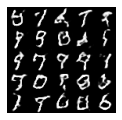

Time for epoch 19 is 13.07760763168335 sec
Epoch: 20/20


Current step 9360: 100%|██████████| 468/468 [00:11<00:00, 40.00it/s, disc_loss=1.24, gen_loss=0.906]


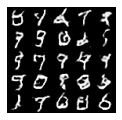

Time for epoch 20 is 12.581233024597168 sec


In [312]:
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

train_iterator = iter(dataset)
steps_per_epoch = DATASET_SIZE // GLOBAL_BATCH_SIZE

for epoch in range(1, EPOCHS + 1):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
 
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=True);
  
  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

In [313]:
anim_file = SAMPLES_DIR + '/all_images.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

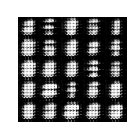

In [314]:
IPython.display.Image(filename=anim_file, embed=True)